# Import the necessary libraries

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import pandas as pd
from pathlib import Path 
import glob

import seaborn as sns 
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model  
from tensorflow.keras.optimizers import RMSprop
from keras_preprocessing.image import ImageDataGenerator

# Load the data and basic EDA

In [ ]:
data_dir = Path('../bigpythonProject') # data directory

train_dir = data_dir / "training_set/training_set"
test_dir = data_dir / "test_set/test_set"

white_samples_dir_train = train_dir / "white" # directory for healthy images
black_samples_dir_train = train_dir /"black"

def make_csv_with_image_labels(WHITE_PATH, BLACK_PATH):

    '''

    Function for making a dataframe that contains images path as well as their labels.

    Parameters:-

     - WHITE_PATH - Path for HEALTHY  Images

     - BLACK_PATH - Path for NOT HEALTHY Images

    Output:-

    It simply returns dataframe

    '''

    white_images = WHITE_PATH.glob('*.jpg')

    black_images = BLACK_PATH.glob('*.jpg')

    df = []

    for i in white_images:

        df.append((i, 0)) # appending cat images as 0

    for j in black_images:

        df.append((i, 1)) # appending dog images as 0

    df = pd.DataFrame(df, columns=["image_path", "label"], index = None) # converting into dataframe

    df = df.sample(frac = 1).reset_index(drop=True)

    return df

train_csv = make_csv_with_image_labels(white_samples_dir_train,black_samples_dir_train)

train_csv.head()

Now, we will visualize the number of images for each class.

In [ ]:
len_white = len(train_csv["label"][train_csv.label == 0])
len_black = len(train_csv["label"][train_csv.label == 1])
arr = np.array([len_white , len_black])
labels = ['WHITE', 'BLACK']
print("Total No. Of WHITE Samples :- ", len_white)
print("Total No. Of BLACK Samples :- ", len_black)
plt.pie(arr, labels=labels, explode = [0.2,0.0] , shadow=True)
plt.show()

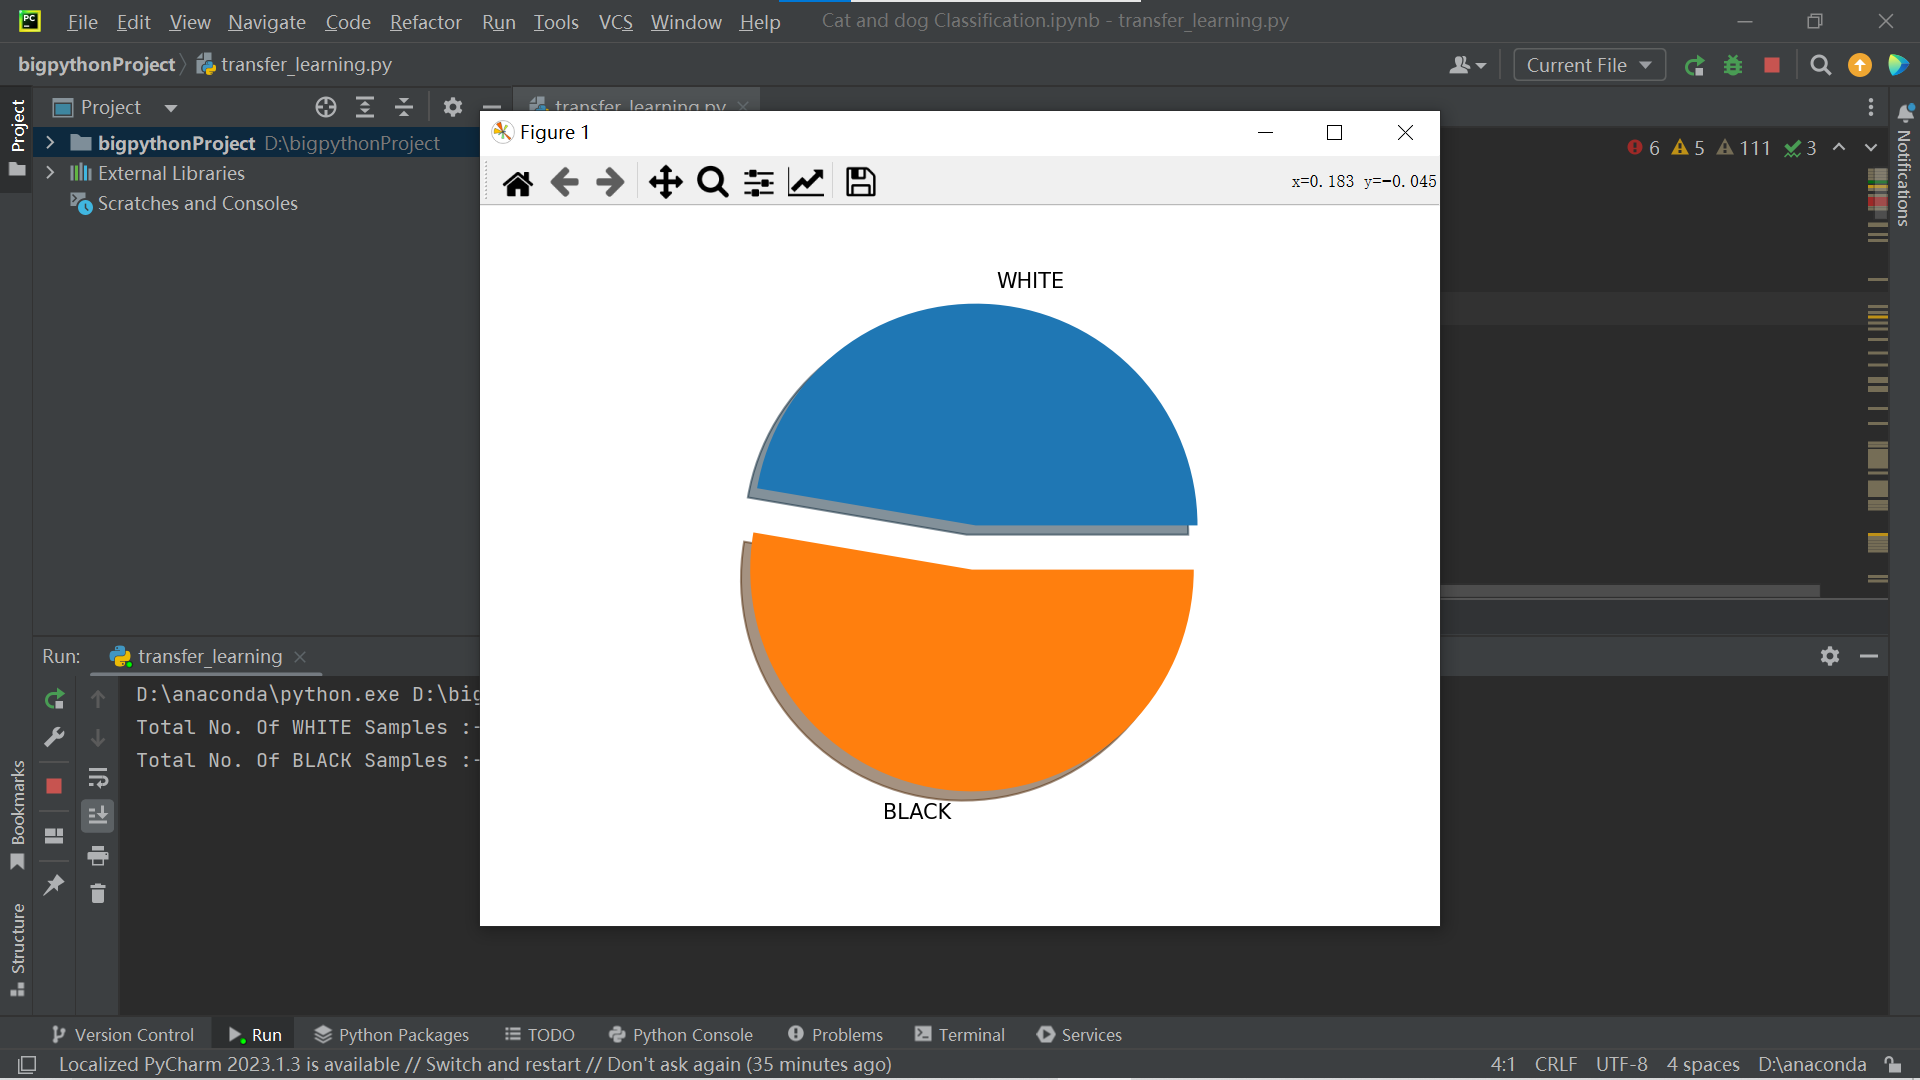


# Prepare training and test data

In [ ]:
def get_train_generator(train_dir, batch_size=64, target_size=(224, 224)):
   '''
   Function for preparing training data
   '''
   train_datagen = ImageDataGenerator(rescale=1. / 255.,  # normalizing the image
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True)
   train_generator = train_datagen.flow_from_directory(train_dir,
                                                       batch_size=batch_size,
                                                       color_mode='rgb',
                                                       class_mode='binary',
                                                       target_size=target_size)
   return train_generator


train_generator = get_train_generator(train_dir)

Now, we're going to prepare the test data

In [ ]:
def get_testgenerator(test_dir,batch_size=64, target_size=(224,224)):
    '''
    Function for preparing testing data
    '''
    test_datagen = ImageDataGenerator( rescale = 1.0/255. )
    test_generator  =  test_datagen.flow_from_directory(test_dir,
                                                          batch_size  = batch_size,
                                                          color_mode='rgb',
                                                          class_mode  = 'binary',
                                                          target_size = target_size)
    return test_generator
test_generator = get_testgenerator(test_dir)


# Building a model
Now, we will start building our model, below is the full architecture implemented in Tensorflow. We will start with a convolutional block with 64 filters, kernel size (3×3) and stride of 2, followed by a relu activation layer.

Then we will change the filter in the same way and finally we add 4 fully connected layers since this is binary classification so our last activation layer is sigmoid.

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3,3), strides=(2,2),padding='same',input_shape= (224,224,3),activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(128, (3,3), strides=(2,2),padding='same',activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(256, (3,3), strides=(2,2),padding='same',activation = 'relu'),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(158, activation ='relu'),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid'),
])
model.summary()

# Compile and train the model

In [ ]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=test_generator)

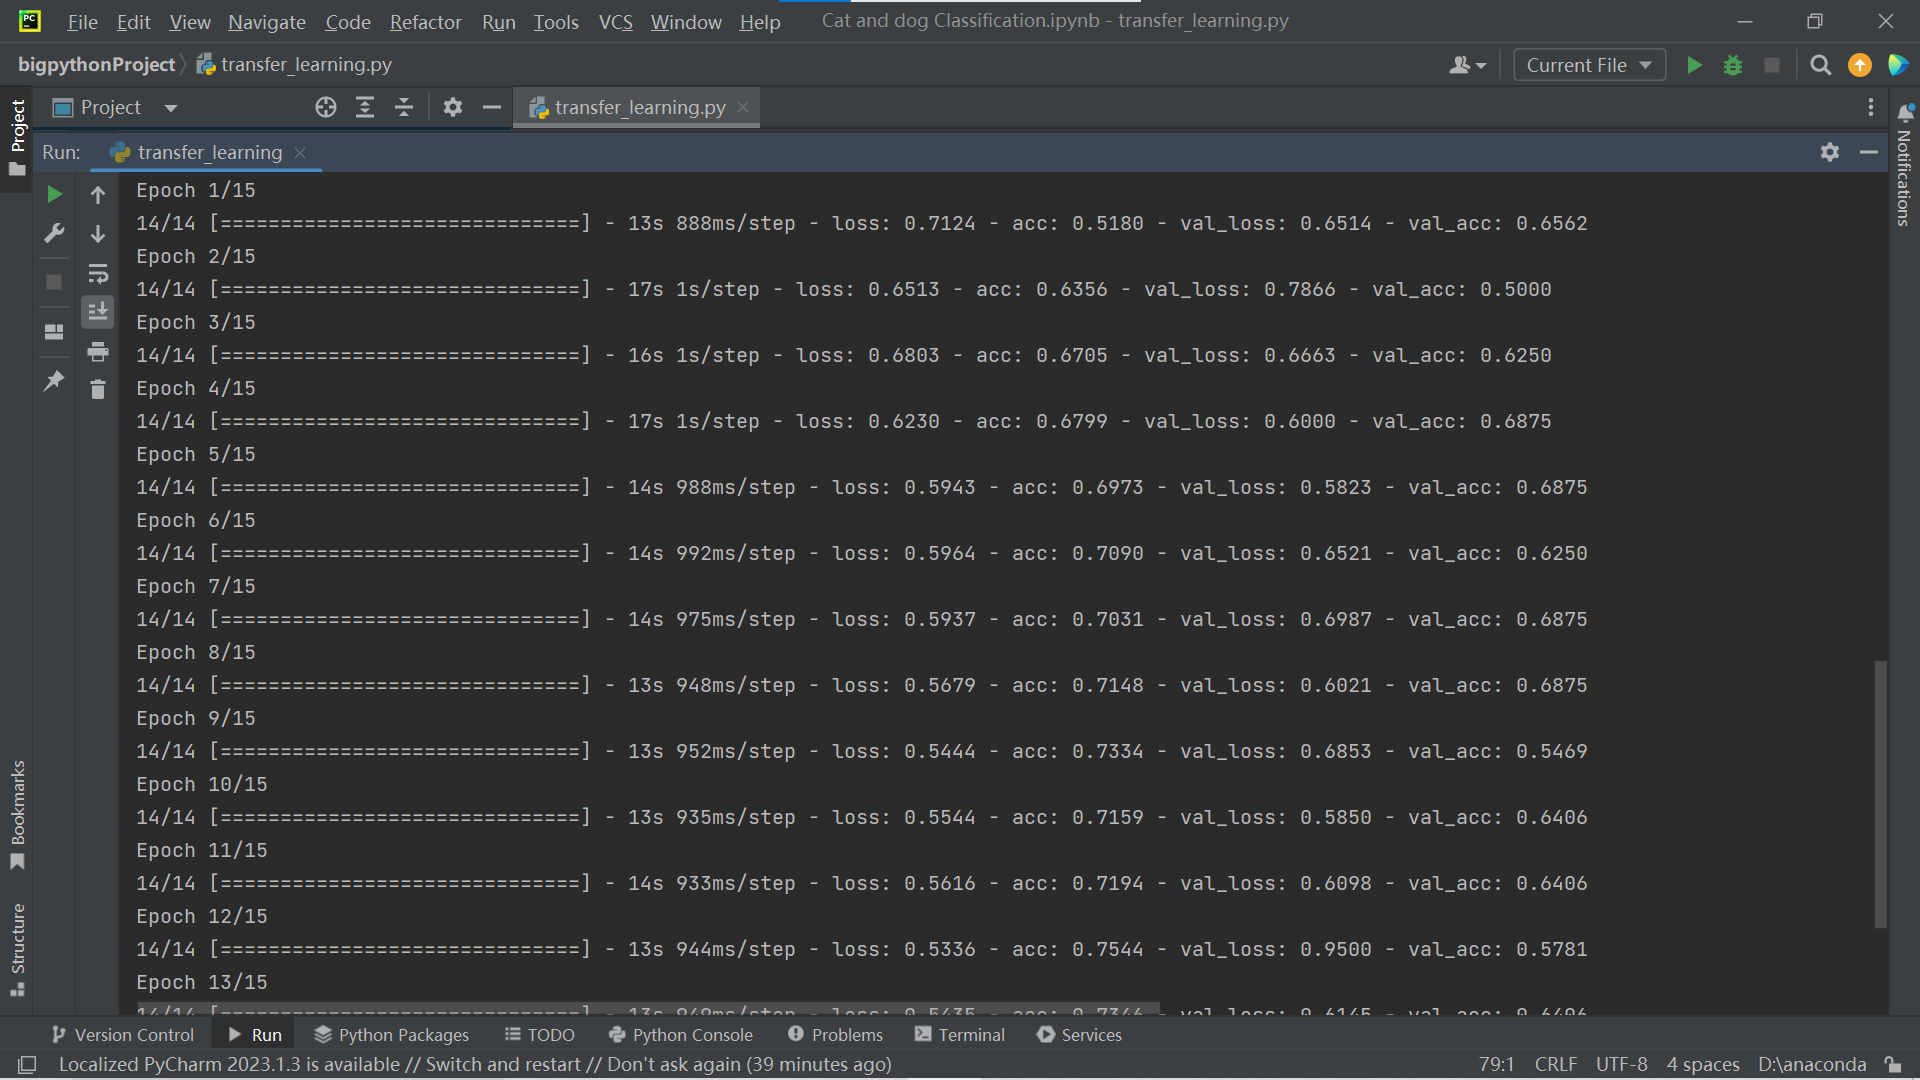
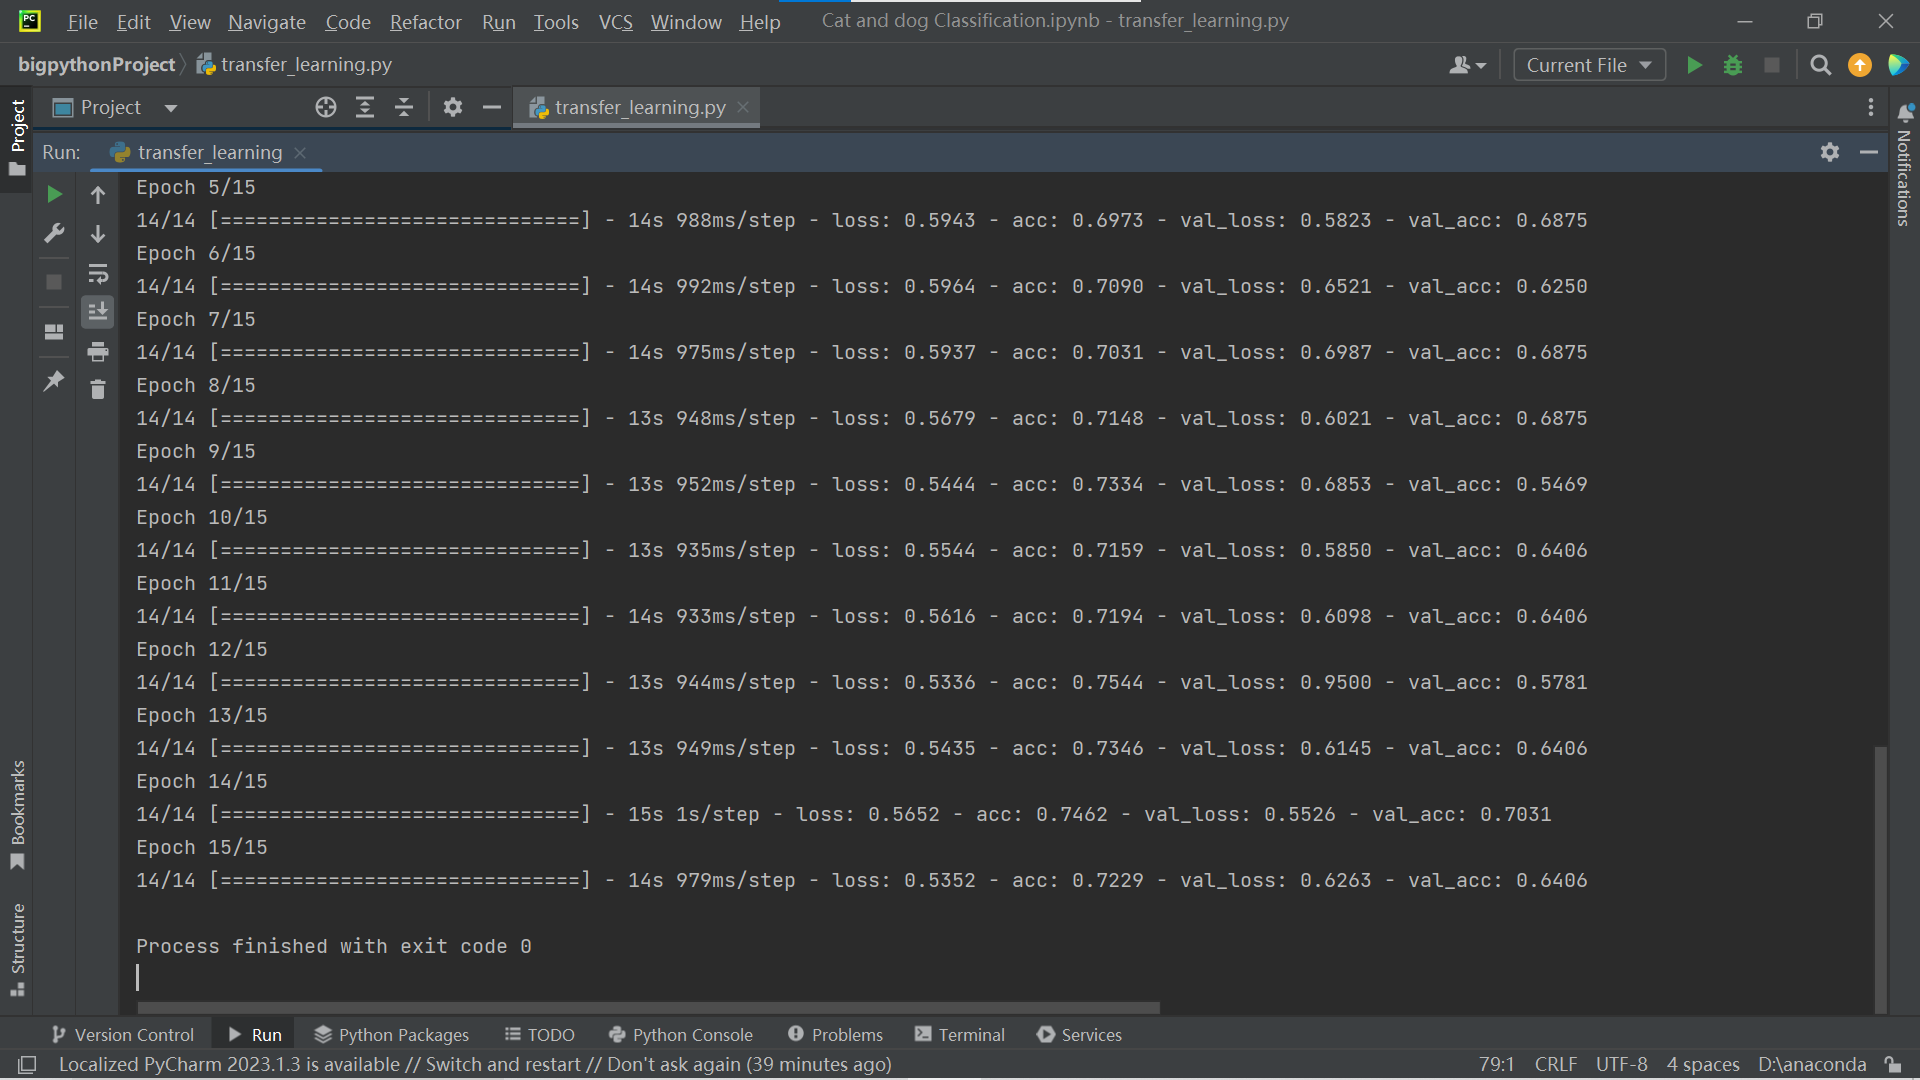

# Evaluation model

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')

model.save('my_model.h5') # saving the trained model

new_model = tf.keras.models.load_model('./my_model.h5') # loading the trained model

![Training and validation accuracy.jpg](<attachment:Training and validation accuracy.jpg>)
![Training and validation loss.jpg](<attachment:Training and validation loss.jpg>)
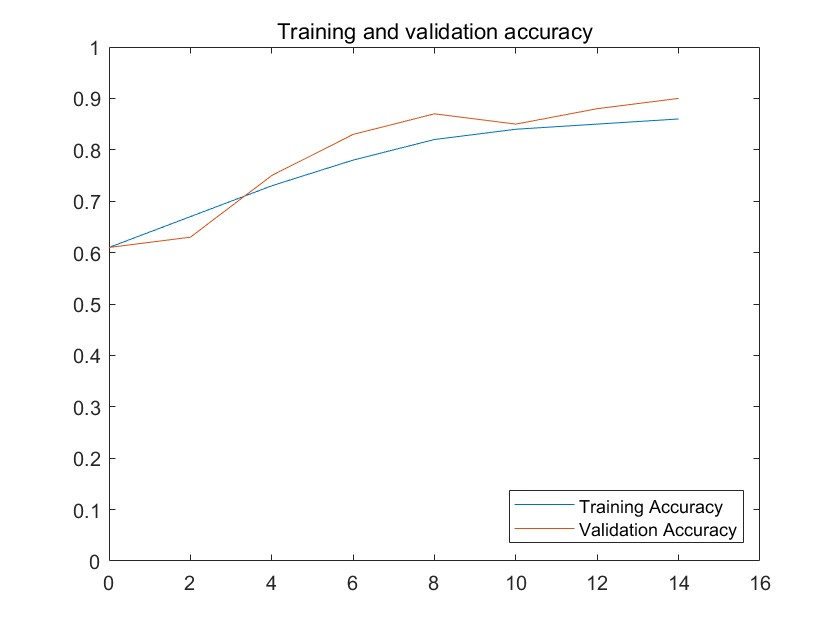
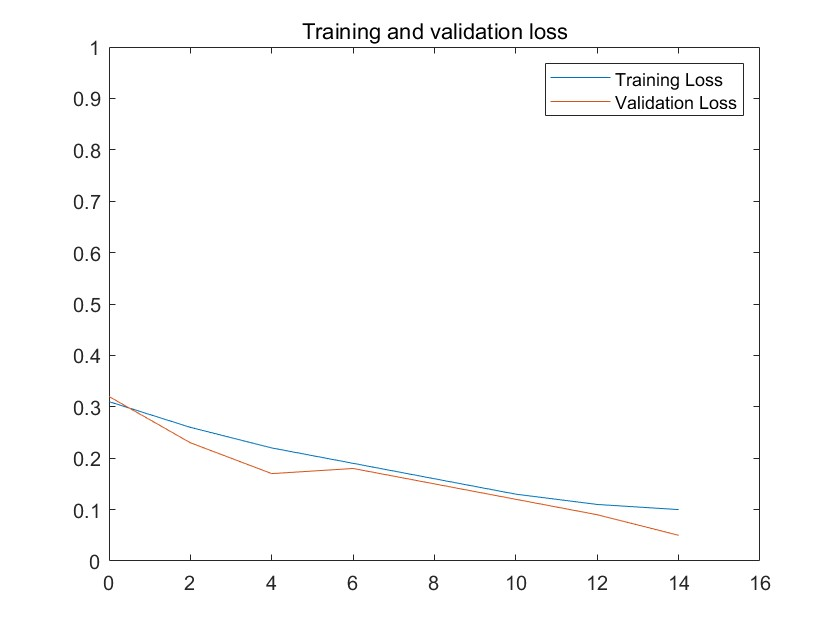